In [1]:
import collections
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
class Game():

    def __init__(self):
        self.symbols = {1:'X', -1:'0', 0:' '}
        self.action_space = self.get_action_space()
        self.board = np.zeros((3, 3))  
        self.x = 1  # player 1
        self.o = -1  # player 2
        self.winner = None  
        self.gameOver = False 
        self.max_states = 3 ** (3 * 3)  # =19683, total number of possible states for tic tac toe game
        
    
    def get_random_action(self):
        while True:
            idx = random.randint(0, 8)
            if self.is_empty(idx):
                return idx
        
    
    def reset(self):
        self.board = np.zeros((3, 3))
        self.winner = None  
        self.gameOver = False 
        return self.get_state()

        
    def is_empty(self, idx):
        i, j = self.action_space[idx]
        return self.board[i, j] == 0
    
    
    def get_action_space(self):
        action_dict = {}
        idx = 0
        for i in range(3):
            for j in range(3):
                action_dict[idx] = (i, j)
                idx += 1
        return action_dict
    
    
    def step(self, action, symbol):
        self.move(action, symbol)
        
        state = self.get_state()
#         self.print_board()
        reward = self.get_reward(symbol)
        is_done = self.is_game_over()
        
        
        return state, reward, is_done, self.winner
    
    
    def move(self, action, symbol):
        i, j = self.action_space[action]
        self.board[i, j] = symbol

    
    def get_reward(self, symbol):
        collected_reward = 0
        if self.is_game_over():
            if self.winner == symbol:
                collected_reward = 1
#                 print('winner', self.symbols[self.winner])
            elif self.winner != None:
                collected_reward = -1
#                 print('winner', self.symbols[self.winner])
#             else:
#                 print('draw')
        return collected_reward

    
    def is_draw(self):
        if self.gameOver and self.winner is None: 
            return True
        return False
    
    
    def get_state(self):
        # returns state as an integer
        state = 0
        loop_index = 0
        for i in range(3):
            for j in range(3):
                if self.board[i, j] == self.x:
                    state_value = 1
                elif self.board[i, j] == self.o:
                    state_value = 2
                else:
                    state_value = 0  # empty

                state += (3 ** loop_index) * state_value
                loop_index += 1
        return state

    
    def is_game_over(self):
        if self.gameOver:  
            return True

        players = [self.x, self.o]

        # check if there are any same symbols on rows side
        for i in range(3):
            for player in players:
                if self.board[i].sum() == player * 3: 
                    self.winner = player
                    self.gameOver = True
                    return True 

        # check if there are any same symbols on columns side
        for j in range(3):
            for player in players:
                if self.board[:, j].sum() == player * 3:
                    self.winner = player
                    self.gameOver = True
                    return True 

        # finally if there is no same symbols on either rows or columns we check on diagonal sides
        for player in players:
            # top-left -> bottom-right diagonal
            # trace() function Return the sum along diagonals of the array
            if self.board.trace() == player * 3:
                self.winner = player
                self.gameOver = True
                return True 

            # top-right -> bottom-left diagonal
            if np.fliplr(self.board).trace() == player * 3:
                self.winner = player
                self.gameOver = True
                return True  

        # no winner
        board_with_true_false = self.board == 0
        if np.all(board_with_true_false == False):
            self.winner = None
            self.gameOver = True
            return True 

        # if game is not over
        self.winner = None
        return False

    
    # array of coords
    def get_empty_cells(self):
        empty_cells = []
        for i in range(3):
            for j in range(3):
                if self.is_empty(i, j):
                    empty_cells.append((i, j))
        return empty_cells

    
    def print_board(self):
        print('-' * 40)
        for row in self.board:
            print(' | '.join(self.symbols[el] for el in row))
            print('-' * 9)

In [16]:
GAMMA = 0.9
TEST_EPISODES = 200

In [17]:
class O_Agent:
    def __init__(self, env):
        self.symbol = env.o
        
    def select_action(self, env, state):
        return env.get_random_action()

In [18]:
action_space_n = 9

class X_Agent:
    def __init__(self, env):
        self.symbol = env.x
        # 3 tables
        self.rewards = collections.defaultdict(float)
        # probabilities of transitioning from one state to another
        self.transits = collections.defaultdict(collections.Counter)
        self.values = collections.defaultdict(float)
        
        
    def calc_value(self, old_state, action):
        state_count = self.transits[(old_state, action)]
        sum_counts = sum(state_count.values())
        Q = 0.0
        for state, count in state_count.items():
            reward = self.rewards[(old_state, action, state)]
            Q += (count / sum_counts) * (reward + GAMMA * self.values[state])
        return Q
    
    
    # evaluate all actions and select action with best value
    def select_action(self, env, state):
        best_action, best_value = None, None
        for action in range(action_space_n):
            value = self.calc_value(state, action)
            if env.is_empty(action) and (best_value is None or best_value < value):
                best_value = value
                best_action = action
        return best_action
    
    
    # calculate values of state and assign best value. do it for each state
    def value_iteration(self):
        for state in range(action_space_n):
            state_values = [self.calc_value(state, action) for action in range(action_space_n)]
            self.values[state] = max(state_values)

In [19]:
# random experience
def play_n_random_steps(count, env, agent_x):
    current_player = env.x
    state = env.reset()
    for _ in range(count):    
        # random action
        action = env.get_random_action()
        new_state, reward, is_done, _ = env.step(action, current_player)
        
        if current_player == env.x:
            agent_x.rewards[(state, action, new_state)] = reward
            agent_x.transits[(state, action)][new_state] += 1
            
            current_player = env.o
        else:
            current_player = env.x
            
        state = env.reset() if is_done else new_state
              
        
def play_episode(env, agent_x, agent_o):
    total_reward = 0.0
    state = env.reset()
    current_player = agent_x
    while True:
        action = current_player.select_action(env, state)
        new_state, reward, is_done, winner = env.step(action, current_player.symbol)
        
        if current_player == agent_x:
            agent_x.rewards[(state, action, new_state)] = reward
            agent_x.transits[(state, action)][new_state] += 1
            total_reward += reward
            
            current_player = agent_o
        else:
            current_player = agent_x
            
        if is_done:
            break
            
        state = new_state

    return total_reward, winner

In [28]:
test_env = Game()
agent_x = X_Agent(test_env)
agent_o = O_Agent(test_env)

In [29]:
iter_no = 0

best_wins = 0.0
wins = []

while True:
    iter_no += 1
    play_n_random_steps(100, test_env, agent_x)
    agent_x.value_iteration()
    
    mean_wins = 0.0
    for _ in range(TEST_EPISODES):
        reward, winner = play_episode(test_env, agent_x, agent_o)
        if winner == test_env.x:
            mean_wins += 1
    mean_wins /= TEST_EPISODES
    wins.append(mean_wins)
        
    if mean_wins > best_wins:
        print('Best win updated %.3f -> %.3f' % (best_wins, mean_wins))
        best_wins = mean_wins
    if mean_wins > 0.94:
        print('Solved in %d iterations' % iter_no)
        break

Best win updated 0.000 -> 0.785
Best win updated 0.785 -> 0.825
Best win updated 0.825 -> 0.850
Best win updated 0.850 -> 0.875
Best win updated 0.875 -> 0.880
Best win updated 0.880 -> 0.885
Best win updated 0.885 -> 0.890
Best win updated 0.890 -> 0.895
Best win updated 0.895 -> 0.900
Best win updated 0.900 -> 0.905
Best win updated 0.905 -> 0.910
Best win updated 0.910 -> 0.920
Best win updated 0.920 -> 0.930
Best win updated 0.930 -> 0.935
Best win updated 0.935 -> 0.940
Best win updated 0.940 -> 0.945
Solved in 2040 iterations


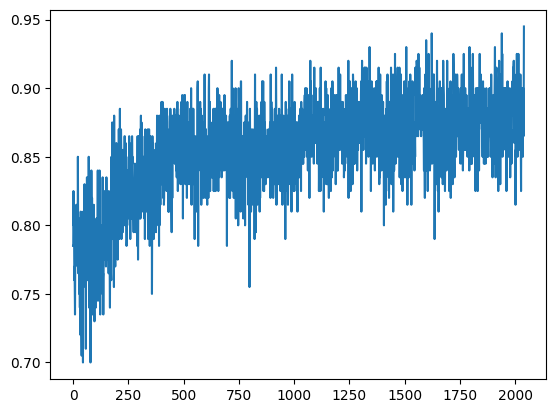

In [30]:
plt.plot(wins)
plt.show()